<a href="https://colab.research.google.com/github/BorisLoveDev/agents-of-uniform-difficulty/blob/main/fit10rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import os
import random
np.random.seed(42)
random.seed(42)

In [2]:
from google.colab import drive
# Подключение Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Загрузка и нормализация данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

num_classes = 10

# Добавление измерения канала к данным
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Применение one-hot encoding
y_test_ohe = to_categorical(y_test, num_classes)
y_train_ohe = to_categorical(y_train, num_classes)
y_train_ohe.shape

11490434/11490434 [==============================] - 2s 0us/step


(60000, 10)

In [4]:
# Загрузка данных для уровня сложности 0
x_data_level_0 = np.load('/content/drive/MyDrive/all_difficulty_data_mnist/x_data_difficult_level_0.npy')
y_data_level_0 = np.load('/content/drive/MyDrive/all_difficulty_data_mnist/y_data_difficult_level_0.npy')

# Загрузка данных для уровня сложности 6
x_data_level_6 = np.load('/content/drive/MyDrive/all_difficulty_data_mnist/x_data_difficult_level_6.npy')
y_data_level_6 = np.load('/content/drive/MyDrive/all_difficulty_data_mnist/y_data_difficult_level_6.npy')


In [5]:
# Функция для деформации изображения, как определено ранее
def deform_image_optimized(image, A, B, M=28, NP=5):
    C = M / (NP + 1.0)
    XN, YN = np.zeros(M), np.zeros(M)
    DX, DY = np.linspace(0, M-1, M), np.linspace(0, M-1, M)

    for j in range(NP):
        TXN = (j + 0.5 - np.random.random()) * C
        TYN = (j + 0.5 - np.random.random()) * C
        TDX = (j + 0.5 - np.random.random()) * C
        TDY = (j + 0.5 - np.random.random()) * C
        AXN = B * (1.0 - 2.0 * np.random.random())
        AYN = B * (1.0 - 2.0 * np.random.random())
        ADX = A * (1.0 - 2.0 * np.random.random())
        ADY = A * (1.0 - 2.0 * np.random.random())
        PXN = (0.1 + 0.9 * np.random.random()) * C
        PYN = (0.1 + 0.9 * np.random.random()) * C
        PDX = (0.1 + 0.9 * np.random.random()) * C
        PDY = (0.1 + 0.9 * np.random.random()) * C

        DX += ADX * np.exp(-((DX - TDX) / PDX)**2)
        DY += ADY * np.exp(-((DY - TDY) / PDY)**2)
        XN += AXN * np.exp(-((DX - TXN) / PXN)**2)
        YN += AYN * np.exp(-((DY - TYN) / PYN)**2)

    deformed_image = np.zeros((M, M))
    for j in range(M):
        for i in range(M):
            x_index = int(DX[i] + XN[j])
            y_index = int(DY[j] + YN[i])
            if 0 <= x_index < M and 0 <= y_index < M:
                deformed_image[j, i] = image[y_index, x_index] if y_index < image.shape[0] and x_index < image.shape[1] else 0

    return deformed_image

In [6]:
deform_params = {
    "1": (0.2, 1.0),
    "2": (0.4, 3.0),
    "3": (1, 5.0),
    "4": (3.5, 9.5),
    "5": (5, 15.0),
}

Получение таблицы ответов для 10 акторов

In [7]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, LeakyReLU, ELU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf


In [8]:

def create_random_cnn_model(input_shape=(28, 28, 1), num_classes=11):
    model = Sequential()

    conv_layer = random.choice([Conv2D, SeparableConv2D])
    filters = random.randint(16, 64)
    kernel_size = random.choice([(3, 3), (5, 5)])
    activation = random.choice(['relu', 'leaky_relu', 'elu', 'selu', 'swish'])

    model.add(conv_layer(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=input_shape))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    num_layers = random.randint(1, 3)
    for _ in range(num_layers):
        conv_layer = random.choice([Conv2D, SeparableConv2D])
        filters = random.randint(16, 128)
        kernel_size = random.choice([(3, 3), (5, 5)])
        activation = random.choice(['relu', 'leaky_relu', 'elu', 'selu', 'swish'])

        if activation == 'selu':
            model.add(conv_layer(filters=filters, kernel_size=kernel_size, activation='selu', padding='same'))
        else:
            model.add(conv_layer(filters=filters, kernel_size=kernel_size, padding='same'))
            if activation == 'leaky_relu':
                model.add(LeakyReLU(alpha=0.01))
            elif activation == 'elu':
                model.add(ELU(alpha=1.0))
            elif activation == 'swish':
                model.add(Activation(tf.nn.swish))
            else:  # relu
                model.add(Activation(activation))

        model.add(BatchNormalization())
        if random.random() < 0.5:
            model.add(MaxPooling2D(pool_size=(2, 2)))
        if random.random() < 0.5:
            model.add(Dropout(rate=random.uniform(0.2, 0.5)))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=random.randint(64, 128), activation='relu'))
    if random.random() < 0.5:
        model.add(Dropout(rate=random.uniform(0.2, 0.5)))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Пример использования
model = create_random_cnn_model(input_shape=(28, 28, 1), num_classes=11)
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])


In [9]:
def split_dataset_with_overlap(data, labels, num_chunks, overlap=0.2):
    chunk_size = len(data) // num_chunks
    overlap_size = int(chunk_size * overlap)

    chunks = []
    for i in range(num_chunks):
        start = i * chunk_size - i * overlap_size
        end = start + chunk_size + overlap_size

        if end > len(data):
            end -= len(data)
            chunk_data = np.concatenate((data[start:], data[:end]))
            chunk_labels = np.concatenate((labels[start:], labels[:end]))
        else:
            chunk_data = data[start:end]
            chunk_labels = labels[start:end]

        chunks.append((chunk_data, chunk_labels))

    data_shapes = [chunk[0].shape for chunk in chunks]
    labels_shapes = [chunk[1].shape for chunk in chunks]

    print(f"Формы данных: {data_shapes}")
    print(f"Формы меток: {labels_shapes}")

    return chunks  # Возвращаем список чанков


In [10]:
def process_chunks(chunks, num_classes=11):
    processed_chunks = []

    for chunk_data, chunk_labels in chunks:
        # Выбираем случайные A и B для этого чанка
        A = random.uniform(3.5, 12.0 - 0.5)
        A = round(A / 0.5) * 0.5
        B = random.randint(9, 32)

        augmented_images = []
        augmented_labels = []

        # Деформируем и добавляем 1000 случайных изображений как специальный класс 10
        for _ in range(1000):
            random_index = random.randint(0, len(chunk_data) - 1)
            image = chunk_data[random_index].squeeze()
            deformed_image = deform_image_optimized(image, A, B)
            augmented_images.append(deformed_image.reshape(28, 28, 1))
            augmented_labels.append(10)

        # Объединяем исходные данные и метки с дополненными
        chunk_data_augmented = np.concatenate((chunk_data, augmented_images))
        chunk_labels_augmented = np.concatenate((chunk_labels, augmented_labels))

        # Перемешивание дополненных данных и меток
        chunk_data_augmented, chunk_labels_augmented = shuffle(chunk_data_augmented, chunk_labels_augmented, random_state=42)

        # Применение one-hot encoding к дополненным меткам
        chunk_labels_augmented = np.eye(num_classes)[chunk_labels_augmented]

        processed_chunks.append((chunk_data_augmented, chunk_labels_augmented))

    return processed_chunks

In [11]:
num_chunks = 10  # Например, разделим на 10 частей
num_classes = 11
chunks = split_dataset_with_overlap(x_train, y_train, num_chunks, overlap=0.2)
processed_chunks = process_chunks(chunks)


Формы данных: [(7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1)]
Формы меток: [(7200,), (7200,), (7200,), (7200,), (7200,), (7200,), (7200,), (7200,), (7200,), (7200,)]


Информация о чанке 0:
Форма данных: (8200, 28, 28, 1)
Форма меток: (8200, 11)
Распределение классов:
Класс 0: 713.0
Класс 1: 809.0
Класс 2: 694.0
Класс 3: 735.0
Класс 4: 734.0
Класс 5: 629.0
Класс 6: 725.0
Класс 7: 770.0
Класс 8: 673.0
Класс 9: 718.0
Класс 10: 1000.0


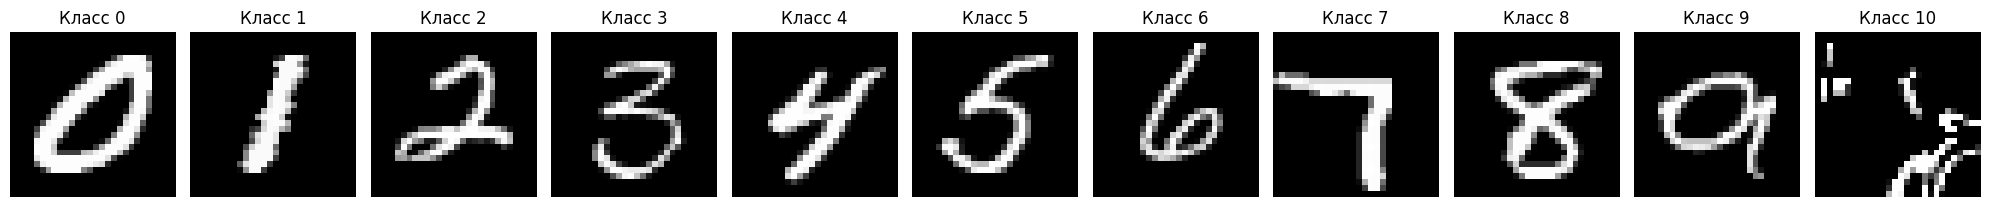

Информация о чанке 1:
Форма данных: (8200, 28, 28, 1)
Форма меток: (8200, 11)
Распределение классов:
Класс 0: 745.0
Класс 1: 817.0
Класс 2: 704.0
Класс 3: 754.0
Класс 4: 666.0
Класс 5: 629.0
Класс 6: 728.0
Класс 7: 755.0
Класс 8: 682.0
Класс 9: 720.0
Класс 10: 1000.0


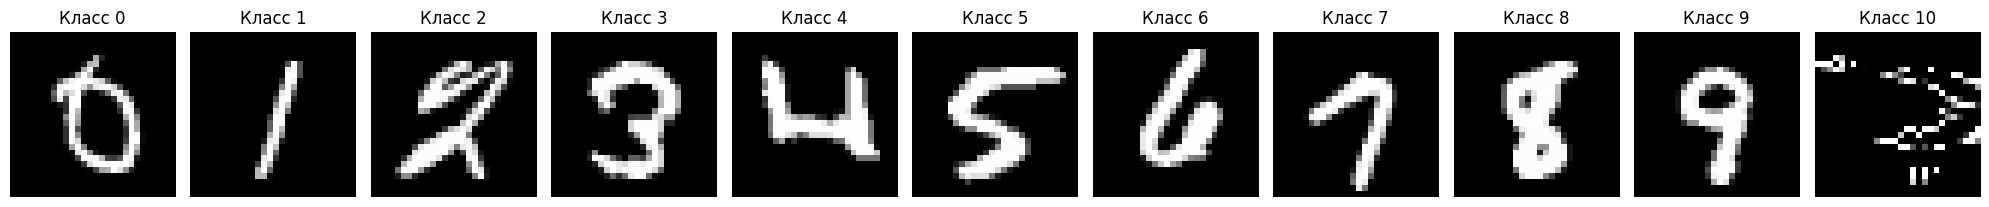

Информация о чанке 2:
Форма данных: (8200, 28, 28, 1)
Форма меток: (8200, 11)
Распределение классов:
Класс 0: 724.0
Класс 1: 816.0
Класс 2: 693.0
Класс 3: 759.0
Класс 4: 664.0
Класс 5: 661.0
Класс 6: 689.0
Класс 7: 743.0
Класс 8: 708.0
Класс 9: 743.0
Класс 10: 1000.0


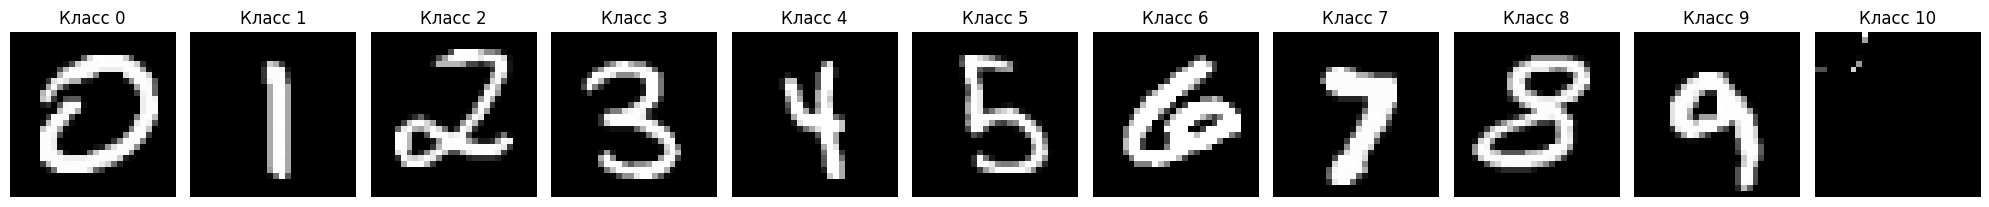

Информация о чанке 3:
Форма данных: (8200, 28, 28, 1)
Форма меток: (8200, 11)
Распределение классов:
Класс 0: 704.0
Класс 1: 844.0
Класс 2: 681.0
Класс 3: 759.0
Класс 4: 693.0
Класс 5: 651.0
Класс 6: 698.0
Класс 7: 720.0
Класс 8: 704.0
Класс 9: 746.0
Класс 10: 1000.0


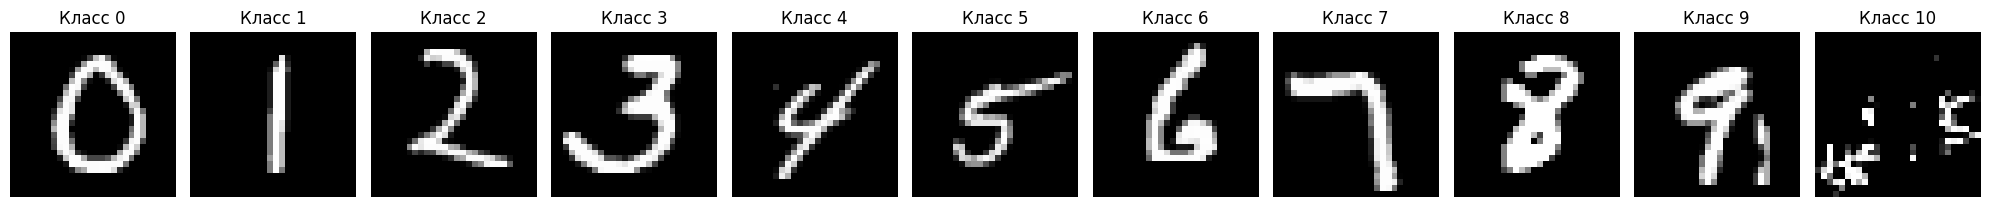

Информация о чанке 4:
Форма данных: (8200, 28, 28, 1)
Форма меток: (8200, 11)
Распределение классов:
Класс 0: 698.0
Класс 1: 820.0
Класс 2: 726.0
Класс 3: 737.0
Класс 4: 720.0
Класс 5: 674.0
Класс 6: 714.0
Класс 7: 728.0
Класс 8: 680.0
Класс 9: 703.0
Класс 10: 1000.0


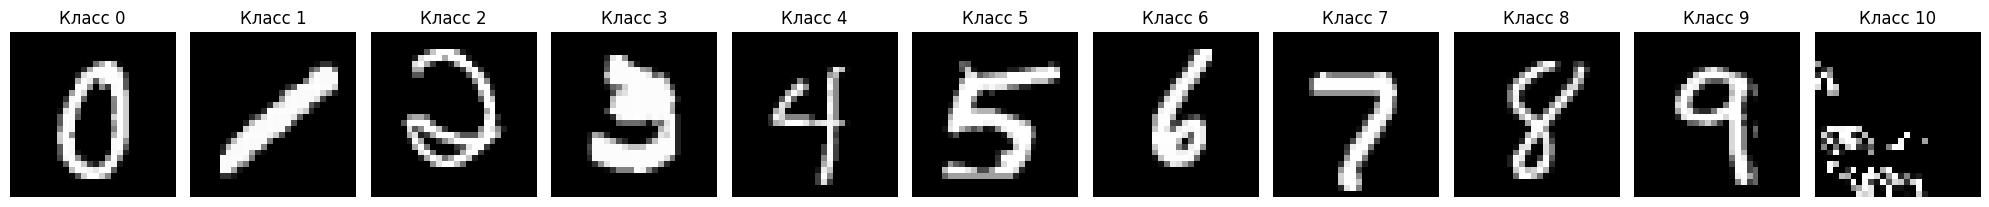

Информация о чанке 5:
Форма данных: (8200, 28, 28, 1)
Форма меток: (8200, 11)
Распределение классов:
Класс 0: 703.0
Класс 1: 829.0
Класс 2: 721.0
Класс 3: 703.0
Класс 4: 693.0
Класс 5: 658.0
Класс 6: 725.0
Класс 7: 747.0
Класс 8: 701.0
Класс 9: 720.0
Класс 10: 1000.0


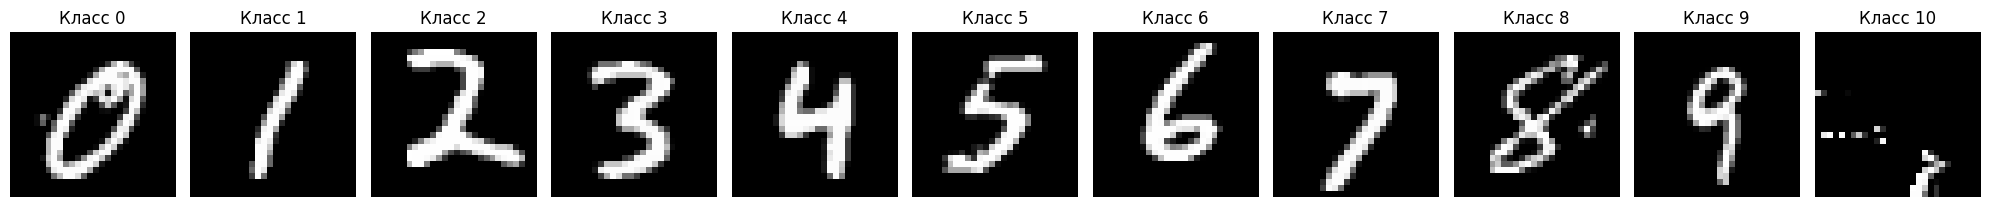

Информация о чанке 6:
Форма данных: (8200, 28, 28, 1)
Форма меток: (8200, 11)
Распределение классов:
Класс 0: 703.0
Класс 1: 824.0
Класс 2: 707.0
Класс 3: 723.0
Класс 4: 703.0
Класс 5: 634.0
Класс 6: 711.0
Класс 7: 735.0
Класс 8: 714.0
Класс 9: 746.0
Класс 10: 1000.0


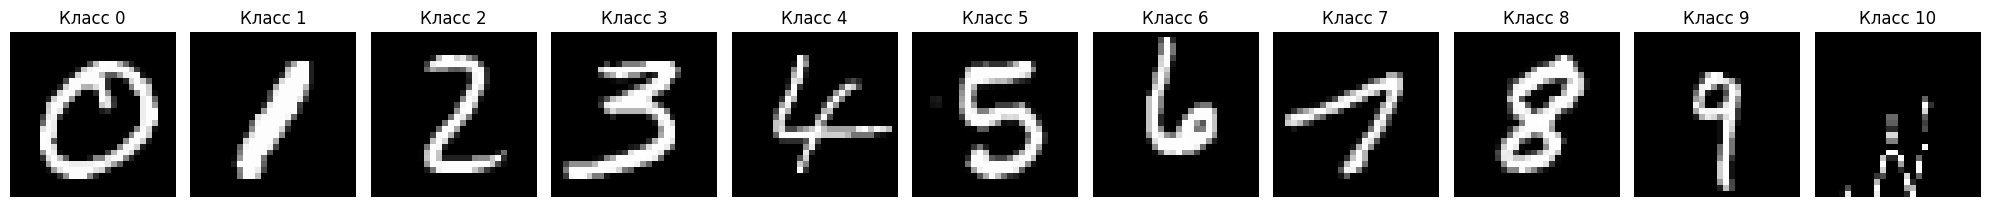

Информация о чанке 7:
Форма данных: (8200, 28, 28, 1)
Форма меток: (8200, 11)
Распределение классов:
Класс 0: 714.0
Класс 1: 803.0
Класс 2: 722.0
Класс 3: 730.0
Класс 4: 719.0
Класс 5: 640.0
Класс 6: 718.0
Класс 7: 733.0
Класс 8: 706.0
Класс 9: 715.0
Класс 10: 1000.0


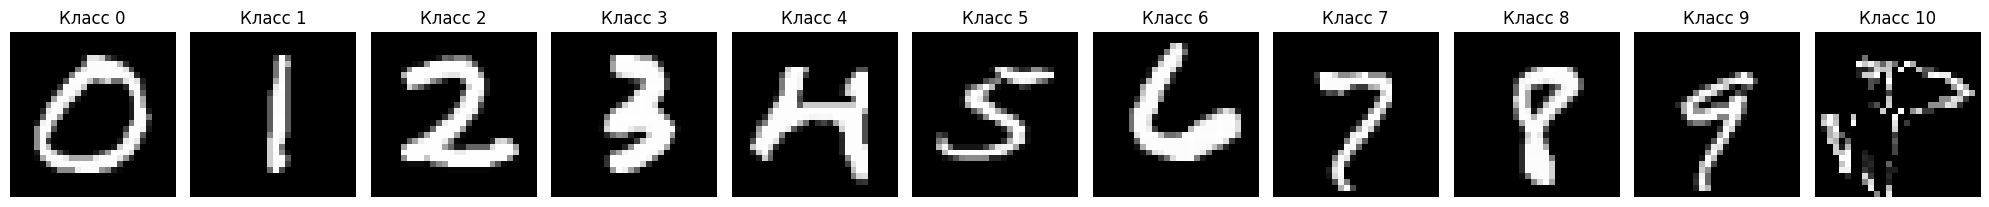

Информация о чанке 8:
Форма данных: (8200, 28, 28, 1)
Форма меток: (8200, 11)
Распределение классов:
Класс 0: 730.0
Класс 1: 827.0
Класс 2: 721.0
Класс 3: 691.0
Класс 4: 679.0
Класс 5: 662.0
Класс 6: 709.0
Класс 7: 761.0
Класс 8: 699.0
Класс 9: 721.0
Класс 10: 1000.0


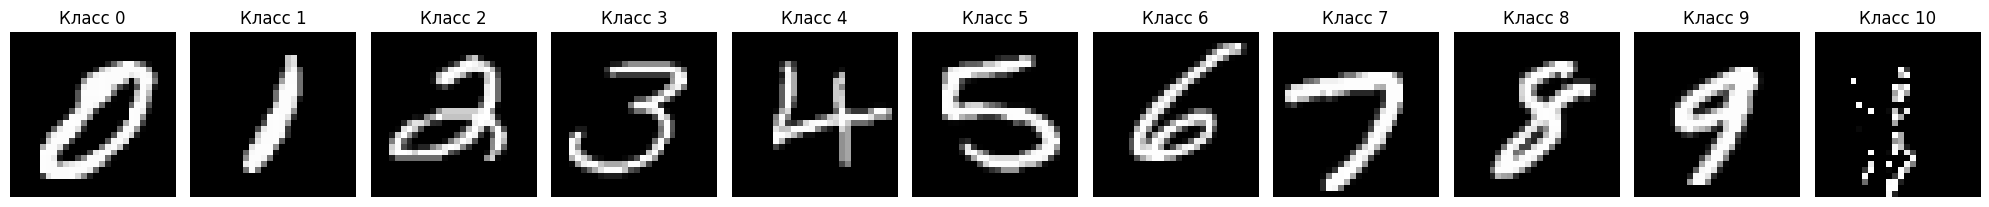

Информация о чанке 9:
Форма данных: (8200, 28, 28, 1)
Форма меток: (8200, 11)
Распределение классов:
Класс 0: 713.0
Класс 1: 784.0
Класс 2: 722.0
Класс 3: 755.0
Класс 4: 690.0
Класс 5: 652.0
Класс 6: 706.0
Класс 7: 757.0
Класс 8: 729.0
Класс 9: 692.0
Класс 10: 1000.0


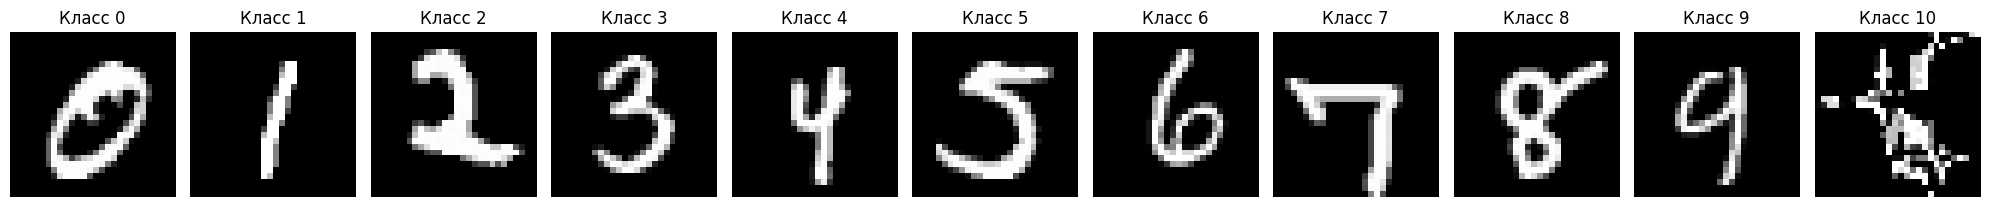

In [12]:
for i, (chunk_data, chunk_labels) in enumerate(processed_chunks):
    print(f"Информация о чанке {i}:")
    print(f"Форма данных: {chunk_data.shape}")
    print(f"Форма меток: {chunk_labels.shape}")

    # Проверка распределения классов в чанке
    class_counts = np.sum(chunk_labels, axis=0)
    print("Распределение классов:")
    for j, count in enumerate(class_counts):
        print(f"Класс {j}: {count}")

    # Вывод примеров данных с каждым лейблом
    fig, axes = plt.subplots(1, num_classes, figsize=(20, 2))
    for j in range(num_classes):
        label_indices = np.where(chunk_labels[:, j] == 1)[0]
        if len(label_indices) > 0:
            example_index = label_indices[0]
            example_image = chunk_data[example_index]
            axes[j].imshow(example_image.squeeze(), cmap='gray')
            axes[j].set_title(f"Класс {j}")
            axes[j].axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate_models(processed_chunks, num_models=3, num_classes=11):
    models = []
    for _ in range(num_models):
        model = create_random_cnn_model(input_shape=(28, 28, 1), num_classes=num_classes)
        models.append(model)

    train_chunks = processed_chunks[:3]
    val_chunk = processed_chunks[3]
    test_chunk = processed_chunks[4]

    for i, model in enumerate(models):
        print(f"Training model {i+1}")
        model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

        train_data = np.concatenate([chunk[0] for chunk in train_chunks])
        train_labels = np.concatenate([chunk[1] for chunk in train_chunks])

        val_data, val_labels = val_chunk

        history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=10, batch_size=128)

        test_data, test_labels = test_chunk
        predicted_labels = model.predict(test_data).argmax(axis=1)
        true_labels = test_labels.argmax(axis=1)

        print(f"Model {i+1} Classification Report:")
        print(classification_report(true_labels, predicted_labels))

        print(f"Model {i+1} Confusion Matrix:")
        print(confusion_matrix(true_labels, predicted_labels))

        print("\n")

# Пример использования
num_chunks = 5
chunks = split_dataset_with_overlap(x_train, y_train, num_chunks, overlap=0.2)
processed_chunks = process_chunks(chunks)

train_and_evaluate_models(processed_chunks)

Формы данных: [(14400, 28, 28, 1), (14400, 28, 28, 1), (14400, 28, 28, 1), (14400, 28, 28, 1), (14400, 28, 28, 1)]
Формы меток: [(14400,), (14400,), (14400,), (14400,), (14400,)]
Training model 1
Epoch 1/10
361/361 [==============================] - 10s 12ms/step - loss: 0.7968 - accuracy: 0.7768 - val_loss: 11.4612 - val_accuracy: 0.0839
Epoch 2/10
361/361 [==============================] - 3s 9ms/step - loss: 0.2158 - accuracy: 0.9385 - val_loss: 1.2829 - val_accuracy: 0.6168
Epoch 3/10
361/361 [==============================] - 3s 8ms/step - loss: 0.1601 - accuracy: 0.9508 - val_loss: 0.1682 - val_accuracy: 0.9481
Epoch 4/10
361/361 [==============================] - 3s 8ms/step - loss: 0.1388 - accuracy: 0.9576 - val_loss: 0.1867 - val_accuracy: 0.9399
Epoch 5/10
361/361 [==============================] - 3s 9ms/step - loss: 0.1204 - accuracy: 0.9627 - val_loss: 0.1072 - val_accuracy: 0.9662
Epoch 6/10
361/361 [==============================] - 4s 11ms/step - loss: 0.1075 - accurac

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def train_and_evaluate_models_with_augmentation(processed_chunks, num_models=10, num_classes=11):
    models = []
    for _ in range(num_models):
        model = create_random_cnn_model(input_shape=(28, 28, 1), num_classes=num_classes)
        models.append(model)

    save_dir = "/content/drive/MyDrive/all_difficulty_data_mnist/weights_100rcnn_normal_train_data"
    os.makedirs(save_dir, exist_ok=True)

    for i, model in enumerate(models):
        print(f"Training model {i+1}")
        model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

        train_chunk = processed_chunks[i]
        val_chunk = processed_chunks[(i+2) % len(processed_chunks)]

        train_data, train_labels = train_chunk
        val_data, val_labels = val_chunk

        if i % 2 == 1:  # Аугментация данных для каждой четной сети
            train_data_augmented = []
            train_labels_augmented = []
            for j in range(len(train_data)):
                img = train_data[j]
                label = train_labels[j]
                aug_iter = datagen.flow(np.expand_dims(img, axis=0), batch_size=1)
                aug_img = next(aug_iter)[0]
                train_data_augmented.append(aug_img)
                train_labels_augmented.append(label)
            train_data = np.array(train_data_augmented)
            train_labels = np.array(train_labels_augmented)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(os.path.join(save_dir, f"model_{i+1}_best.keras"), save_best_only=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

        history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels),
                            epochs=100, batch_size=64, callbacks=[early_stopping, model_checkpoint, reduce_lr])

        test_chunk = processed_chunks[(i+1) % len(processed_chunks)]
        test_data, test_labels = test_chunk
        predicted_labels = model.predict(test_data).argmax(axis=1)
        true_labels = test_labels.argmax(axis=1)

        print(f"Model {i+1} Classification Report:")
        print(classification_report(true_labels, predicted_labels))

        print(f"Model {i+1} Confusion Matrix:")
        print(confusion_matrix(true_labels, predicted_labels))

        print("\n")

# Пример использования
num_chunks = 10
chunks = split_dataset_with_overlap(x_train, y_train, num_chunks, overlap=0.2)
processed_chunks = process_chunks(chunks)

train_and_evaluate_models_with_augmentation(processed_chunks)

Формы данных: [(7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1), (7200, 28, 28, 1)]
Формы меток: [(7200,), (7200,), (7200,), (7200,), (7200,), (7200,), (7200,), (7200,), (7200,), (7200,)]
Training model 1
Epoch 1/100
129/129 [==============================] - 5s 14ms/step - loss: 1.0060 - accuracy: 0.6921 - val_loss: 5.5341 - val_accuracy: 0.0913 - lr: 0.0010
Epoch 2/100
129/129 [==============================] - 1s 10ms/step - loss: 0.2947 - accuracy: 0.9195 - val_loss: 5.6150 - val_accuracy: 0.1201 - lr: 0.0010
Epoch 3/100
129/129 [==============================] - 2s 13ms/step - loss: 0.1990 - accuracy: 0.9434 - val_loss: 2.9530 - val_accuracy: 0.3850 - lr: 0.0010
Epoch 4/100
129/129 [==============================] - 2s 12ms/step - loss: 0.1456 - accuracy: 0.9599 - val_loss: 0.9830 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 5/100
129/129 [=========================